In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Global Settings

In [42]:
path_gdrive = '/content/drive/Shareddrives/DMP-W23/Repo/data/'

sns.set(rc={'figure.figsize':(12, 10)})

## Data

In [3]:
census = pd.read_csv(path_gdrive + 'OUTPUT_census_starter_impute_bymonth.csv', header=0)
unemp = pd.read_csv(path_gdrive + 'OUTPUT_unemployment.csv', header=0, index_col=0)
income = pd.read_csv(path_gdrive + 'OUTPUT_income.csv', header=0, index_col=0)
yields = pd.read_csv(path_gdrive + 'OUTPUT_10yr_yield.csv', header=0)
rent = pd.read_csv(path_gdrive + 'OUTPUT_annual_rent.csv', header=0)
tax = pd.read_csv(path_gdrive + 'OUTPUT_marg_corp_tax.csv', header=0)
train = pd.read_csv(path_gdrive + 'train.csv', header=0)

In [4]:
train['year'] = pd.to_datetime(train['first_day_of_month']).dt.year
train['month'] = pd.to_datetime(train['first_day_of_month']).dt.month

## Quick Quality Check

### Census

In [5]:
census.head(5)

,cfips,month,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers
0,1001,1,2017,55317.0,76.6,14.5,2.1,1.3
1,1001,1,2018,58786.0,78.9,15.9,2.0,1.1
2,1001,1,2019,58731.0,80.6,16.1,2.3,0.7
3,1001,1,2020,57982.0,82.7,16.7,2.3,0.6
4,1001,1,2021,62660.0,85.5,16.4,2.1,1.1


In [6]:
# Need to check with group
census.isna().sum(axis=0)

cfips                0
month                0
year                 0
median_hh_inc       60
pct_bb              24
pct_college         24
pct_foreign_born    24
pct_it_workers      36
dtype: int64

In [7]:
# Each cfips county has five years
(census.groupby('cfips')['year'].nunique() == 5).all()

True

In [8]:
# Join keys
census_keys = ['cfips', 'year', 'month']
# Values
census_vals = list(set(census.columns) - set(census_keys))

### Unemployment

In [9]:
unemp.head(5)

,series_id,year,period,rate,cfips
0,LAUCN010010000000003,2017,M01,0.052,1001
1,LAUCN010010000000003,2017,M02,0.049,1001
2,LAUCN010010000000003,2017,M03,0.043,1001
3,LAUCN010010000000003,2017,M04,0.037,1001
4,LAUCN010010000000003,2017,M05,0.035,1001


In [10]:
unemp.rename(columns={'rate': 'monthly_unemp_rate'}, inplace=True)

In [11]:
unemp.isna().sum(axis=0)

series_id             0
year                  0
period                0
monthly_unemp_rate    0
cfips                 0
dtype: int64

In [12]:
# Some counties only have 3 years of data
np.unique(unemp.groupby('cfips')['year'].nunique())

array([3, 6])

In [13]:
unemp['year'].unique()

array([2017, 2018, 2019, 2020, 2021, 2022])

In [14]:
np.unique(unemp.groupby('cfips')['period'].nunique())

array([13])

Drop M13 (annual average)

In [15]:
unemp = unemp.loc[~(unemp.period == 'M13')].copy()

Derive month from 'period':

In [16]:
unemp['month'] = np.vectorize(lambda val: int(val[-2:]))(unemp['period'].values)

unemp['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [17]:
unemp_keys = ['cfips', 'year', 'month']
unemp_vals = ['monthly_unemp_rate']

### Income

In [18]:
income.head(5)

,cfips,county,state,date,earning,year
0,1001,Autauga County,Alabama,2019-01-01,978.982509,2019
1,1001,Autauga County,Alabama,2019-02-01,989.515111,2019
2,1001,Autauga County,Alabama,2019-03-01,985.190158,2019
3,1001,Autauga County,Alabama,2019-04-01,979.594556,2019
4,1001,Autauga County,Alabama,2019-05-01,969.377859,2019


In [19]:
income.rename(columns={'date': 'first_day_of_month'}, inplace=True)

In [20]:
(income.groupby('cfips')['year'].nunique() == 4).all()

True

In [21]:
income['year'].unique()

array([2019, 2020, 2021, 2022])

In [22]:
income_keys = ['cfips', 'first_day_of_month']
income_vals = ['earning']

### Yields

In [23]:
yields.head(5)

,first_day_of_month,DGS10
0,2018-01-01,2.55
1,2018-02-01,2.91
2,2018-03-01,2.81
3,2018-04-01,2.82
4,2018-05-01,3.00


In [24]:
yields.rename(columns={'DGS10': 'treasury_yield_10yr'}, inplace=True)

In [25]:
yields_key = ['first_day_of_month']
yields_val = ['treasury_yield_10yr']

### Rent

In [26]:
rent.head(5)

,cfips,year,med_rent_zero_bed,med_rent_one_bed,med_rent_two_beds,med_rent_three_beds
0,1001,2019,620.0,743.0,880.0,1112.0
1,1001,2020,615.0,741.0,876.0,1105.0
2,1001,2021,685.0,820.0,972.0,1229.0
3,1001,2022,687.0,816.0,976.0,1234.0
4,1001,2023,773.0,882.0,1055.0,1340.0


In [27]:
rent_keys = ['cfips', 'year']
rent_vals = ['med_rent_zero_bed', 'med_rent_one_bed', 'med_rent_two_beds',	'med_rent_three_beds']

### Tax

In [28]:
tax.head(5)

,state,year,tax_rate,tax_rate_diff
0,Alabama,2008,4.23,0.0
1,Alaska,2008,9.40,0.0
2,Arizona,2008,6.97,0.0
3,Arkansas,2008,6.50,0.0
4,California,2008,8.84,0.0


In [29]:
tax.rename(columns={'tax_rate': 'annual_tax_rate'}, inplace=True)

In [30]:
tax_keys = ['year', 'state']
tax_val = ['annual_tax_rate']

## Join

We now left join the external data onto the training set one by one:

* Train and census

In [31]:
train_census = pd.merge(train, census[census_vals + census_keys], left_on=['cfips', 'year', 'month'], right_on=census_keys, how='left')
train_census.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_foreign_born,pct_bb,median_hh_inc,pct_it_workers,pct_college
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,2.3,80.6,58731.0,0.7,16.1
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,2.3,80.6,58731.0,0.7,16.1
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,2.3,80.6,58731.0,0.7,16.1
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,2.3,80.6,58731.0,0.7,16.1
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,2.3,80.6,58731.0,0.7,16.1
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,2.3,82.7,57982.0,0.6,16.7
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,2.3,82.7,57982.0,0.6,16.7
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,2.3,82.7,57982.0,0.6,16.7
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,2.3,82.7,57982.0,0.6,16.7
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,2.3,82.7,57982.0,0.6,16.7


* Train, census, and income

In [32]:
train_census_income = pd.merge(train_census, income[income_vals + income_keys], left_on=income_keys, right_on=income_keys, how='left')
train_census_income.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_foreign_born,pct_bb,median_hh_inc,pct_it_workers,pct_college,earning
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,2.3,80.6,58731.0,0.7,16.1,984.159963
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,2.3,80.6,58731.0,0.7,16.1,1002.543389
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,2.3,80.6,58731.0,0.7,16.1,999.057181
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,2.3,80.6,58731.0,0.7,16.1,996.766106
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,2.3,80.6,58731.0,0.7,16.1,1020.530595
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,2.3,82.7,57982.0,0.6,16.7,1003.815865
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,2.3,82.7,57982.0,0.6,16.7,1012.500022
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,2.3,82.7,57982.0,0.6,16.7,1015.524888
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,2.3,82.7,57982.0,0.6,16.7,1042.283728
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,2.3,82.7,57982.0,0.6,16.7,1050.169686


* Train, census, income, and yield

In [33]:
train_census_income_yield = pd.merge(train_census_income, yields[yields_key + yields_val], left_on=['first_day_of_month'], right_on=yields_key, how='left')
train_census_income_yield.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_foreign_born,pct_bb,median_hh_inc,pct_it_workers,pct_college,earning,treasury_yield_10yr
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,2.3,80.6,58731.0,0.7,16.1,984.159963,1.59
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,2.3,80.6,58731.0,0.7,16.1,1002.543389,1.90
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,2.3,80.6,58731.0,0.7,16.1,999.057181,1.76
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,2.3,80.6,58731.0,0.7,16.1,996.766106,1.82
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,2.3,80.6,58731.0,0.7,16.1,1020.530595,1.82
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,2.3,82.7,57982.0,0.6,16.7,1003.815865,1.82
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,2.3,82.7,57982.0,0.6,16.7,1012.500022,1.59
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,2.3,82.7,57982.0,0.6,16.7,1015.524888,0.94
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,2.3,82.7,57982.0,0.6,16.7,1042.283728,0.76
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,2.3,82.7,57982.0,0.6,16.7,1050.169686,0.63


* Trian, census, income, yield, and unemployment

In [34]:
train_census_income_yield_unemp = pd.merge(
    train_census_income_yield, 
    unemp[unemp_keys + unemp_vals], 
    left_on=['cfips', 'year', 'month'], 
    right_on=unemp_keys, 
    how='left'
)
train_census_income_yield_unemp.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_foreign_born,pct_bb,median_hh_inc,pct_it_workers,pct_college,earning,treasury_yield_10yr,monthly_unemp_rate
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,2.3,80.6,58731.0,0.7,16.1,984.159963,1.59,0.029
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,2.3,80.6,58731.0,0.7,16.1,1002.543389,1.90,0.026
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,2.3,80.6,58731.0,0.7,16.1,999.057181,1.76,0.025
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,2.3,80.6,58731.0,0.7,16.1,996.766106,1.82,0.024
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,2.3,80.6,58731.0,0.7,16.1,1020.530595,1.82,0.026
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,2.3,82.7,57982.0,0.6,16.7,1003.815865,1.82,0.034
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,2.3,82.7,57982.0,0.6,16.7,1012.500022,1.59,0.032
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,2.3,82.7,57982.0,0.6,16.7,1015.524888,0.94,0.036
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,2.3,82.7,57982.0,0.6,16.7,1042.283728,0.76,0.111
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,2.3,82.7,57982.0,0.6,16.7,1050.169686,0.63,0.085


* Train, census, income, yield, unemployment, and rent

In [35]:
train_census_income_yield_unemp_rent = pd.merge(
    train_census_income_yield_unemp, 
    rent[rent_keys + rent_vals], 
    left_on=['cfips', 'year'], 
    right_on=rent_keys, 
    how='left'
)
train_census_income_yield_unemp_rent.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_foreign_born,...,median_hh_inc,pct_it_workers,pct_college,earning,treasury_yield_10yr,monthly_unemp_rate,med_rent_zero_bed,med_rent_one_bed,med_rent_two_beds,med_rent_three_beds
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,2.3,...,58731.0,0.7,16.1,984.159963,1.59,0.029,620.0,743.0,880.0,1112.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,2.3,...,58731.0,0.7,16.1,1002.543389,1.90,0.026,620.0,743.0,880.0,1112.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,2.3,...,58731.0,0.7,16.1,999.057181,1.76,0.025,620.0,743.0,880.0,1112.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,2.3,...,58731.0,0.7,16.1,996.766106,1.82,0.024,620.0,743.0,880.0,1112.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,2.3,...,58731.0,0.7,16.1,1020.530595,1.82,0.026,620.0,743.0,880.0,1112.0
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,2.3,...,57982.0,0.6,16.7,1003.815865,1.82,0.034,615.0,741.0,876.0,1105.0
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,2.3,...,57982.0,0.6,16.7,1012.500022,1.59,0.032,615.0,741.0,876.0,1105.0
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,2.3,...,57982.0,0.6,16.7,1015.524888,0.94,0.036,615.0,741.0,876.0,1105.0
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,2.3,...,57982.0,0.6,16.7,1042.283728,0.76,0.111,615.0,741.0,876.0,1105.0
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,2.3,...,57982.0,0.6,16.7,1050.169686,0.63,0.085,615.0,741.0,876.0,1105.0


* Train, census, income, yield, unemployment, rent, and tax

In [36]:
train_census_income_yield_unemp_rent_tax = pd.merge(
    train_census_income_yield_unemp_rent, 
    tax[tax_keys + tax_val], 
    left_on=['year', 'state'], 
    right_on=tax_keys, 
    how='left'
)
train_census_income_yield_unemp_rent_tax.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_foreign_born,...,pct_it_workers,pct_college,earning,treasury_yield_10yr,monthly_unemp_rate,med_rent_zero_bed,med_rent_one_bed,med_rent_two_beds,med_rent_three_beds,annual_tax_rate
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,2.3,...,0.7,16.1,984.159963,1.59,0.029,620.0,743.0,880.0,1112.0,6.03
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,2.3,...,0.7,16.1,1002.543389,1.90,0.026,620.0,743.0,880.0,1112.0,6.03
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,2.3,...,0.7,16.1,999.057181,1.76,0.025,620.0,743.0,880.0,1112.0,6.03
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,2.3,...,0.7,16.1,996.766106,1.82,0.024,620.0,743.0,880.0,1112.0,6.03
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,2.3,...,0.7,16.1,1020.530595,1.82,0.026,620.0,743.0,880.0,1112.0,6.03
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,2.3,...,0.6,16.7,1003.815865,1.82,0.034,615.0,741.0,876.0,1105.0,6.07
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,2.3,...,0.6,16.7,1012.500022,1.59,0.032,615.0,741.0,876.0,1105.0,6.07
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,2.3,...,0.6,16.7,1015.524888,0.94,0.036,615.0,741.0,876.0,1105.0,6.07
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,2.3,...,0.6,16.7,1042.283728,0.76,0.111,615.0,741.0,876.0,1105.0,6.07
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,2.3,...,0.6,16.7,1050.169686,0.63,0.085,615.0,741.0,876.0,1105.0,6.07


## Sanity Check

In [37]:
train_joined = train_census_income_yield_unemp_rent_tax

train_joined.isna().sum(axis=0)

row_id                       0
cfips                        0
county                       0
state                        0
first_day_of_month           0
microbusiness_density        0
active                       0
year                         0
month                        0
pct_foreign_born         31350
pct_bb                   31350
median_hh_inc            31374
pct_it_workers           31350
pct_college              31350
earning                      0
treasury_yield_10yr          0
monthly_unemp_rate          39
med_rent_zero_bed            0
med_rent_one_bed             0
med_rent_two_beds            0
med_rent_three_beds          0
annual_tax_rate              0
dtype: int64

* The census data do not have data for 2022--- it covers the period from 2017 to 2021, leading to missing values; the training set convers the period from 2019 to 2022

* The unemployment data have some counties that have three years of data while the rest have 6 years of data; the training set covers the period from 2019 to 2022

## Adding quarter and year

In [43]:
q = pd.read_csv(path_gdrive + 'quarter_and_holiday.csv', header=0)

In [39]:
train_joined = pd.merge(train_joined, q, on='month')

In [40]:
qy = train_joined.groupby(['quarter','year']).mean().reset_index()

<AxesSubplot:xlabel='quarter', ylabel='microbusiness_density'>

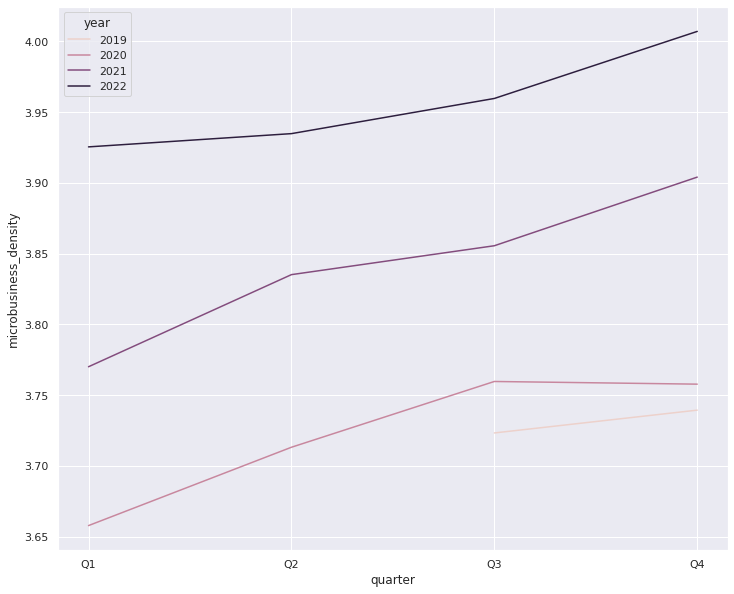

In [44]:
sns.lineplot(data=qy, x='quarter', y='microbusiness_density', hue='year')

<AxesSubplot:xlabel='month', ylabel='microbusiness_density'>

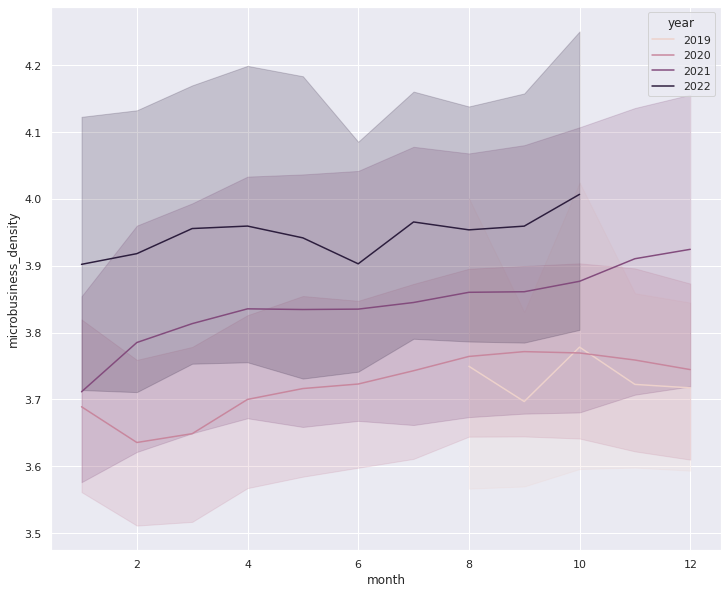

In [45]:
sns.lineplot(data=train_joined, x='month', y='microbusiness_density', hue='year')

In [46]:
qy.sort_values(by=['year', 'month'], ascending=True).head()

,quarter,year,cfips,microbusiness_density,active,month,pct_foreign_born,pct_bb,median_hh_inc,pct_it_workers,pct_college,earning,treasury_yield_10yr,monthly_unemp_rate,med_rent_zero_bed,med_rent_one_bed,med_rent_two_beds,med_rent_three_beds,annual_tax_rate,holiday_season
6,Q3,2019,30376.03764,3.723234,6249.435726,8.5,4.772759,75.415981,53497.915152,1.338341,14.247656,1057.848212,1.745000,0.036621,624.195853,692.163477,865.082616,1153.691069,6.741825,0.000000
10,Q4,2019,30376.03764,3.739352,6291.748857,11.0,4.772759,75.415981,53497.915152,1.338341,14.247656,1056.454557,1.800000,0.036175,624.195853,692.163477,865.082616,1153.691069,6.741825,0.333333
0,Q1,2020,30376.03764,3.657776,6243.297714,2.0,4.752089,78.559649,55043.390236,1.310526,14.639426,1054.748117,1.450000,0.047182,641.898246,708.003190,882.164115,1173.304466,6.679219,0.000000
3,Q2,2020,30376.03764,3.713129,6329.368740,5.0,4.752089,78.559649,55043.390236,1.310526,14.639426,1082.986786,0.700000,0.103249,641.898246,708.003190,882.164115,1173.304466,6.679219,0.000000
7,Q3,2020,30376.03764,3.759606,6405.794152,8.0,4.752089,78.559649,55043.390236,1.310526,14.639426,1078.153866,0.673333,0.067689,641.898246,708.003190,882.164115,1173.304466,6.679219,0.000000


## Income & Tax

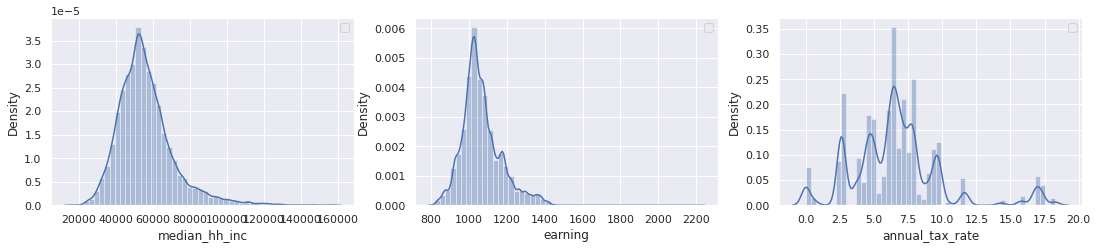

In [47]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

df = train_joined.copy()

l_num = ['median_hh_inc', 'earning', 'annual_tax_rate']

fig = plt.figure(figsize=(25,20))
for i in range(len(l_num)):
    ax=fig.add_subplot(5, 4, i+1)
    #sns.histplot(df[l_num[i]].dropna())
    sns.distplot(df[l_num[i]].dropna())
    ax.set_xlabel(l_num[i])
    ax.legend()

In [48]:
l_num = ['median_hh_inc', 'earning', 'annual_tax_rate']

for num in l_num:
  print(f'variable is: {num}')
  print(df[num].describe())
  print('\n')

variable is: median_hh_inc
count     90891.000000
mean      56106.693556
std       15057.966689
min       17109.000000
25%       46352.000000
50%       53963.000000
75%       62865.000000
max      156821.000000
Name: median_hh_inc, dtype: float64


variable is: earning
count    122265.000000
mean       1065.761455
std         104.841190
min         817.268263
25%        1001.139349
50%        1046.838377
75%        1115.621401
max        2214.289997
Name: earning, dtype: float64


variable is: annual_tax_rate
count    122265.000000
mean          6.638139
std           3.343423
min           0.000000
25%           4.580000
50%           6.500000
75%           7.900000
max          18.280000
Name: annual_tax_rate, dtype: float64




In [ ]:
for num in l_num:
  print(f'variable is: {num}')
  print(df[num].isna().value_counts())
  print('\n')

variable is: median_hh_inc
False    90891
True     31374
Name: median_hh_inc, dtype: int64


variable is: earning
False    122265
Name: earning, dtype: int64


variable is: annual_tax_rate
False    122265
Name: annual_tax_rate, dtype: int64




In [49]:
def percentile_classifier(x, group_percentile):
  '''
  Group classifier. 
  Take: value, and a list of percentile (Q2, Q3)
  Return: a string result referring to the percentile group
  '''
  group = None
  if type(x) != float:
    group = None
  if x < group_percentile['Q2']: # If less than the 2nd quartile value
    group = 'lower_25_percentile'
  elif ((x >= group_percentile['Q2']) & (x <= group_percentile['Q3'])):
    group = 'middle_50_percentile'
  elif (x > group_percentile['Q3'] ): # If greater than the 3rd quartile value
    group = 'upper_75_percentile'
  return group

# Percentile dict
earning_pctile = {'Q2': 1002, 'Q3': 1116} # Quartile values for earnings column (25th and 75th)
tax_pctile = {'Q2': 4.58, 'Q3': 7.9} # Quartile values for tax column (25th and 75th)


df_test = df[['microbusiness_density', 'earning', 'annual_tax_rate']]
df_test['earning_group'] = df_test['earning'].apply(lambda x: percentile_classifier(x, earning_pctile))
df_test['annual_tax_group'] = df_test['annual_tax_rate'].apply(lambda x: percentile_classifier(x, tax_pctile))

df_test.head()

,microbusiness_density,earning,annual_tax_rate,earning_group,annual_tax_group
0,3.007682,984.159963,6.03,lower_25_percentile,middle_50_percentile
1,3.174679,1076.308483,6.07,middle_50_percentile,middle_50_percentile
2,3.219917,1072.861805,6.05,middle_50_percentile,middle_50_percentile
3,3.423852,993.996523,6.04,lower_25_percentile,middle_50_percentile
4,7.239156,984.159963,6.03,lower_25_percentile,middle_50_percentile


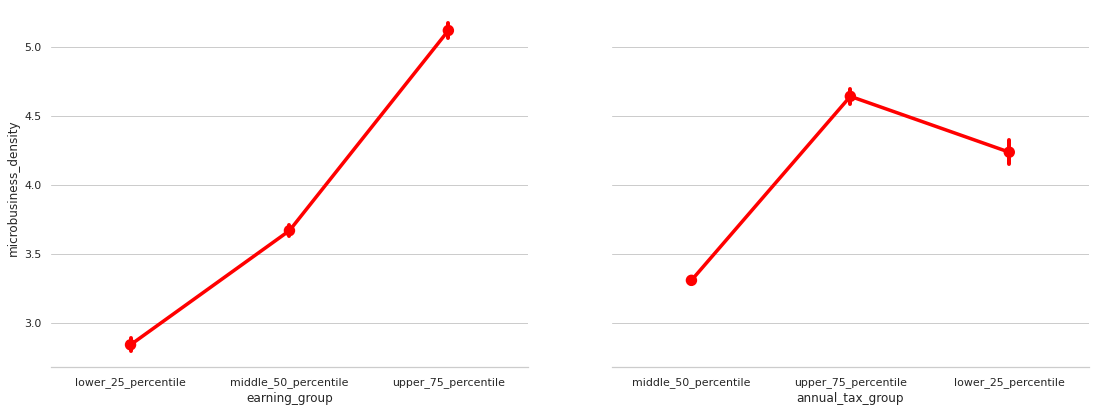

In [50]:
l_cat = ['earning_group', 'annual_tax_group']

sns.set_theme(style="whitegrid")
# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(df_test, y_vars="microbusiness_density",
                 x_vars=l_cat,       # categorical_vars
                 height=5, aspect=.5, size=5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="red")
g.fig.set_figheight(6), g.fig.set_figwidth(18)
sns.despine(fig=g.fig, left=True)

Interpretation:

For income percentile, we can easily tell that the microbusiness density is positively related to the average personal earning.

For tax percentile, we see that high microbusiness density only occurs in region with tax that is either higher than 75 percentile or lower than 25 percentile. A possible rationale is that small business might grow in places with relatively developed economy (and thus it is associated with high corporate tax). Otherwise, microbusiness tends to grow where corporate tax is low.

In [51]:
# Add new columns
train_joined['earning_group'] = train_joined['earning'].apply(lambda x: percentile_classifier(x, earning_pctile))
train_joined['annual_tax_group'] = train_joined['annual_tax_rate'].apply(lambda x: percentile_classifier(x, tax_pctile))

# One-hot encoding the added columns
train_joined = pd.get_dummies(train_joined, columns=['earning_group', 'annual_tax_group'])

## Write to Disk

In [52]:
train_joined.to_csv(path_gdrive + 'train_joined.csv', index=False)